https://ranalytics.github.io/data-mining/044-Ensembles.html
https://habr.com/ru/company/ods/blog/324402/

##### Композиции, беггинг, случайный лес

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 13
plt.rcParams['axes.labelsize'] = 13

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

##### Бутстрап
Пусть имеется выборка $X$ размера $N$. Равномерно возьмем из выборки $N$. Вероятность извлечь объект из выборки равна $p = \frac{1}{N}$ Объект извлекаем с возвращением. Пусть $X_1$ - первое испытание (с возвращением). Проведем $M$ таких испытаний.

In [5]:
PATH_DIR = '../../bases/'
FILE_NAME = 'telecom_churn_data.csv'

PATH_FILE = os.path.join(PATH_DIR, FILE_NAME)
print(os.path.isfile(PATH_FILE))

True


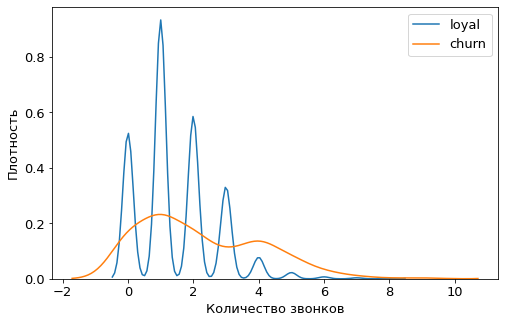

In [6]:
telecom_data = pd.read_csv(PATH_FILE)
fig = sns.kdeplot(telecom_data[telecom_data['churn'] == False]['customer service calls'], 
                  label = 'loyal')
fig = sns.kdeplot(telecom_data[telecom_data['churn'] == True]['customer service calls'],
                 label = 'churn')
fig.set(xlabel='Количество звонков', ylabel='Плотность')
plt.show()

- у лояльных клиентов количество звонков меньше, чем у бывших клиентов;
- оценим средние у этих двух групп (интервальные оценки)

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(low=0, high=len(data), size=(n_samples, len(data)))
    return data[indices]

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100*alpha/2, 100*(1-alpha/2)])
    return boundaries.round(3)

loyal_calls = telecom_data[telecom_data['churn'] == False]['customer service calls'].values
churn_calls = telecom_data[telecom_data['churn'] == True]['customer service calls'].values

np.random.seed(32)

loyal_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_calls, 1000)]

print('Service calls from loyal: mean interval ', stat_intervals(loyal_mean_scores, 0.05))
print('Service calls from churn: mean interval ', stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval  [1.405 1.492]
Service calls from churn: mean interval  [2.072 2.408]


***Итог:*** С вероятностью 95-% среднее число звонков от лояльных клиентов будет лежать в промежутки между 1.405 и 1.492, в то время как бывшие клиенты звонили в среднем от 2.072 до 2.408 раз.

####  Беггинг (bootstrap aggregating)
Пусть имеется обучающая выборка $X$. Сгенерируем с помощью бутсрэпа из нее выборки $X_1, ..., X_m$ и на каждой выборке обучим свой классификатор $b_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию):
$$a(x)=\frac{1}{M}\sum\limits_{i=1}^{M}a_i(x) \notag$$

![title](../media/bagging.png)


#### Out-of-bag error

- каждое дерево строится с использованием разных образцов бутстрэпа и около 37% примеров остаются вне выборки бутсрэпа, которые могу быть исползованы в качестве тестовой выборки.

Пусть в выборке $l$ объектов. Наугад извлекается один объект. Вероятность выбрать один объект равна $\frac{1}{l}$  Проводится $l$ испытаний. Вероятность того, что объект не попадет в подвыборку $(1- \frac{1}{l})^l$. Т.о. 
$$\big(1- \frac{1}{l}\big)^l=\big(\frac{l-1}{l}\big)^l=
    \frac{1}{\big(\frac{l}{l-1}\big)^l} \frac{1}{\big(1+\frac{1}{l-1}\big)^l} \underset {l \to \infty}{\to} \frac{1}{e} \approx 0.37 \notag$$

#### Случайный лес
Сочетание:
- метод некоррелируемых деревьев,
- беггинг,
- метода случайных подпространств.

Алгоритм построения случайного леса, состоящего из $N$ деревьев:
- для каждого $n=\overline{1, N}$ с помощью бутстрапа генерируем выборку $X_n$;
- строим решающее дерево $b_n$ по выборке $X_n$, где для каждого разбиения выбирается $m$ случайных признаков из $n$ исходных.
- итоговый классификатор $a(x)=\frac{1}{N}\sum\limits_{i=1}^{N} b_i(x)$.

Рекомендуется в задачах классификации брать $m=\sqrt{n}$, а в задачах регрессии $-m = \frac{n}{3}$, где $n-$ число признаков.



***Сравнение моделей для задачи регрессии***

In [8]:
import numpy as np 

n_train = 1500
n_test = 100
noise = 0.1

def f(x):
    return np.exp(-x**2) + 1.5*np.exp(-(x-2)**2)

def generate(n_samples, noise):
    
    X = np.random.rand(n_samples)*10 - 5
    X = np.sort(X)
    y = f(X) + np.random.normal(0, noise, n_samples)
    X = X.reshape((n_samples, -1))
    return X, y

X_train, y_train = generate(n_train, noise)
X_test, y_test = generate(n_test, noise)

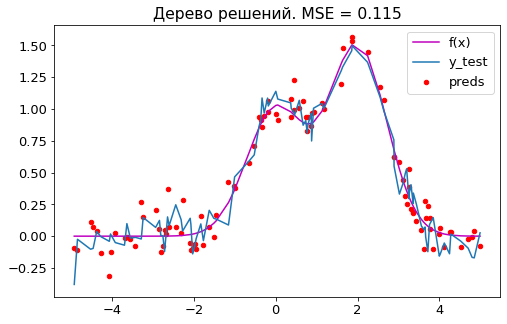

In [9]:
# Decision tree regressor
dtree = DecisionTreeRegressor(criterion='mse', random_state=32).fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.scatter(X_test, d_predict, s=20, label='preds', c='r')
plt.plot(X_test, f(X_test), color='m', label='f(x)')
plt.plot(X_test, y_test, label='y_test')
plt.title(f'Дерево решений. MSE = {mean_absolute_error(y_test, d_predict).round(3)}')
plt.legend()
plt.show()

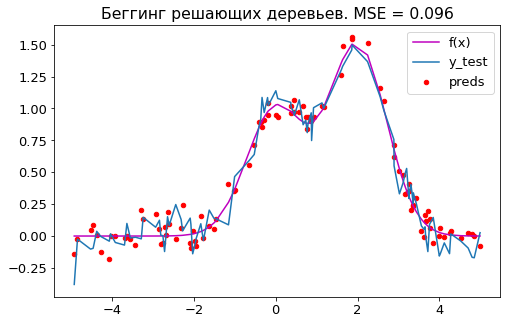

In [10]:
# Bagging decision tree regressor
bdtree = BaggingRegressor(DecisionTreeRegressor(), random_state=32).fit(X_train, y_train)
bdt_predict = bdtree.predict(X_test)

plt.scatter(X_test, bdt_predict, s=20, label='preds', c='r')
plt.plot(X_test, f(X_test), color='m', label='f(x)')
plt.plot(X_test, y_test, label='y_test')
plt.title(f'Беггинг решающих деревьев. MSE = {mean_absolute_error(y_test, bdt_predict).round(3)}')
plt.legend()
plt.show()

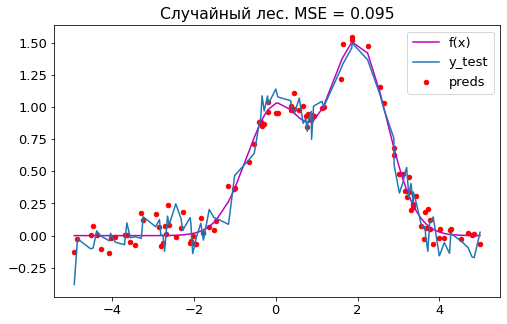

In [11]:
# Random forest regressor
n_estimators = 50
rf = RandomForestRegressor(50, random_state=32).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.scatter(X_test, rf_predict, s=20, label='preds', c='r')
plt.plot(X_test, f(X_test), color='m', label='f(x)')
plt.plot(X_test, y_test, label='y_test')
plt.title(f'Случайный лес. MSE = {mean_absolute_error(y_test, rf_predict).round(3)}')
plt.legend()
plt.show()

***Сравние моделей для задачи классификации***

In [12]:
# генерируем данные
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

x_range = np.linspace(X.ravel().min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
X_cont = np.c_[xx1.ravel(), xx2.ravel()]

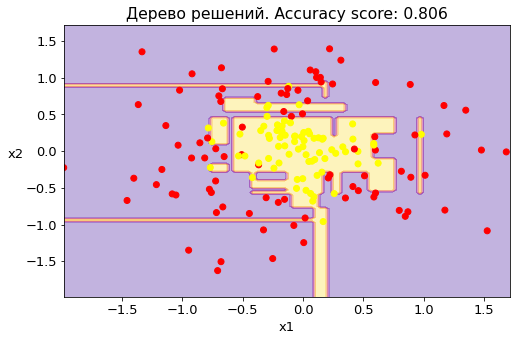

In [13]:
# дерево решений
tree_clf =  DecisionTreeClassifier(random_state=32, criterion='gini')
tree_clf.fit(X_train, y_train)
tree_preds = tree_clf.predict(X_test)
tree_preds_cont = tree_clf.predict(X_cont)

# plt.pcolormesh(xx1, xx2, tree_preds_cont)
plt.contourf(xx1, xx2, tree_preds_cont.reshape(xx1.shape), alpha=0.3, cmap='plasma')
plt.scatter(X_test[:, 0], X_test[:, 1], c=tree_preds, cmap='autumn')
plt.xlabel('x1'), plt.ylabel('x2', rotation=0, labelpad=10)
plt.title(f'Дерево решений. Accuracy score: {accuracy_score(y_test, tree_preds).round(3)}')
plt.show()

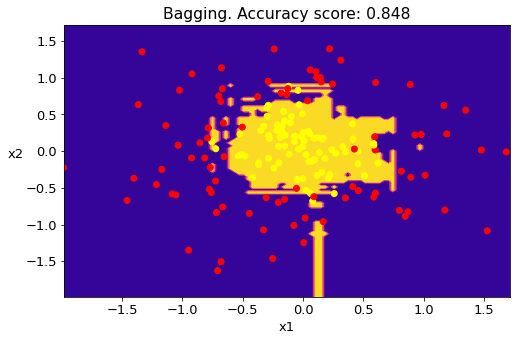

In [14]:
# бэггинг
bag_clf =  BaggingClassifier(DecisionTreeClassifier(criterion='gini'), 
                              n_estimators=50, random_state=32)
bag_clf.fit(X_train, y_train)
bag_clf_preds = bag_clf.predict(X_test)
bag_clf_preds_cont = bag_clf.predict(X_cont)

# plt.pcolormesh(xx1, xx2, tree_preds_cont)
plt.contourf(xx1, xx2, bag_clf_preds_cont.reshape(xx1.shape), cmap='plasma')
plt.scatter(X_test[:, 0], X_test[:, 1], c=bag_clf_preds, cmap='autumn')
plt.xlabel('x1'), plt.ylabel('x2', rotation=0, labelpad=10)
plt.title(f'Bagging. Accuracy score: {accuracy_score(y_test, bag_clf_preds).round(3)}')
plt.show()

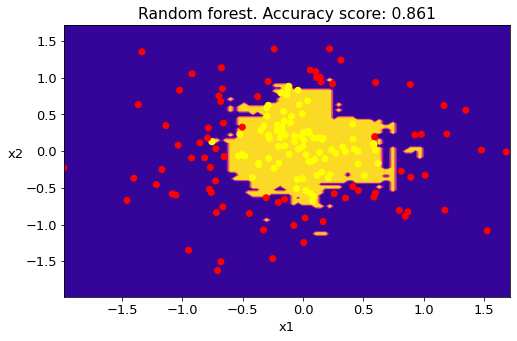

In [15]:
# случайный лес
rf_clf =  RandomForestClassifier(n_estimators=50, criterion='gini', random_state=32)
rf_clf.fit(X_train, y_train)
rf_clf_preds = rf_clf.predict(X_test)
rf_clf_preds_cont = rf_clf.predict(X_cont)

# plt.pcolormesh(xx1, xx2, tree_preds_cont)
plt.contourf(xx1, xx2, rf_clf_preds_cont.reshape(xx1.shape), cmap='plasma')
plt.scatter(X_test[:, 0], X_test[:, 1], c=rf_clf_preds, cmap='autumn')
plt.xlabel('x1'), plt.ylabel('x2', rotation=0, labelpad=10)
plt.title(f'Random forest. Accuracy score: {accuracy_score(y_test, rf_clf_preds).round(3)}')
plt.show()

***Итог*** Раздеяющая граница модели дерево решений существенно отличаются от границы случайного леса и бэггинга - она более рванная. Дерево решений склонно к переобучению.
***Сравнение бэггинга и случайного леса.*** Исследуя разделяющие поверхности бэггинга и случайного лес можно сделать вывод о том, что случайный лес менее склонен к переобучению. Предположительно в силу метода случайных подпространств.

#### Настройка параметров случайного леса

In [19]:
df = pd.read_csv(PATH_FILE)

# выбираем числовые признаки
cols = [i for i in df.columns if (df[i].dtype == 'float64') or (df[i].dtype == 'int64')]
X, y = df[cols].copy(), np.asarray(df['churn'], dtype='int8')

# выбираем стратегию кроссвалидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)

##### Построение кривых валидации по подбору количества деревьев

In [22]:
import warnings
warnings.filterwarnings('ignore')

trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
train_acc = []
test_acc = []

for ntrees in trees_grid:
    
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=32, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print(f'Best accuracy on CV is {max(test_acc.mean(axis=1)*100)}% with ', end='')
print(f'{trees_grid[np.argmax(test_acc.mean(axis=1))]} trees')

warnings.filterwarnings('default')

Best accuracy on CV is 92.55876566221394% with 100 trees


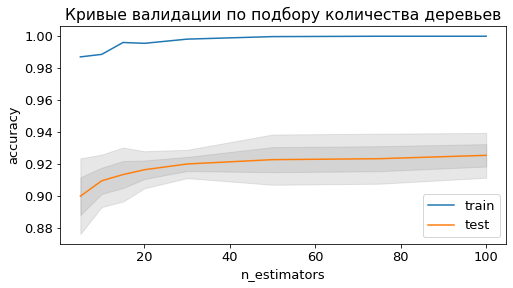

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), label='test')
mu = test_acc.mean(axis=1)
sigma = test_acc.std(axis=1)
ax.fill_between(trees_grid, mu-sigma, mu+sigma, color='#888888', alpha=0.2)
ax.fill_between(trees_grid, mu-2*sigma, mu+2*sigma, color='#888888', alpha=0.2)
ax.set_xlabel('n_estimators')
ax.set_ylabel('accuracy')
ax.legend(loc='best')
plt.title('Кривые валидации по подбору количества деревьев')
plt.show()

##### Построение кривых валидации по подбору максимальной глубины дерева

In [25]:
%%time

max_depth_grid = list(range(3, 25, 2))
train_acc = []
test_acc = []

for max_depth in max_depth_grid:
    
    rfc = RandomForestClassifier(n_estimators=100, random_state=32, max_depth=max_depth,
                                 n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print(f'Best accuracy on CV is {max(test_acc.mean(axis=1)*100)}% with ', end='')
print(f'{max_depth_grid[np.argmax(test_acc.mean(axis=1))]} max_depth');

Best accuracy on CV is 92.64899081990536% with 13 max_depth
CPU times: user 53.7 s, sys: 2.94 s, total: 56.6 s
Wall time: 1min 13s


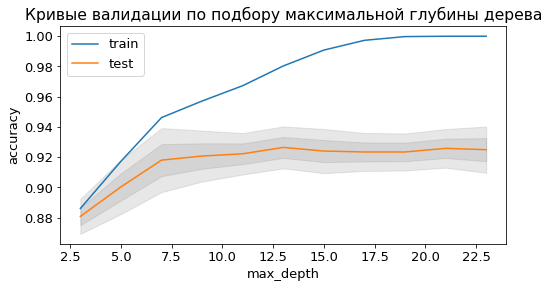

In [26]:
# 
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), label='test')
mu = test_acc.mean(axis=1)
sigma = test_acc.std(axis=1)
ax.fill_between(max_depth_grid, mu-sigma, mu+sigma, color='#888888', alpha=0.2)
ax.fill_between(max_depth_grid, mu-2*sigma, mu+2*sigma, color='#888888', alpha=0.2)
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.legend(loc='best')
plt.title('Кривые валидации по подбору максимальной глубины дерева')
plt.show()

##### Построение кривых валидации по подбору минимального числа объектов в листе

In [27]:
%%time

min_samples_leaf_grid = list(range(1, 25, 2))
train_acc = []
test_acc = []

for min_samples_leaf in min_samples_leaf_grid:
    
    rfc = RandomForestClassifier(n_estimators=100, random_state=32, 
                                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print(f'Best accuracy on CV is {max(test_acc.mean(axis=1)*100)}% with ', end='')
print(f'{min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]} min_samples_leaf');

Best accuracy on CV is 92.55876566221394% with 1 min_samples_leaf
CPU times: user 53.4 s, sys: 893 ms, total: 54.3 s
Wall time: 1min 4s


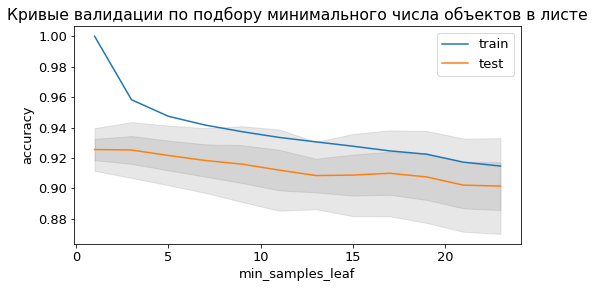

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), label='test')
mu = test_acc.mean(axis=1)
sigma = test_acc.std(axis=1)
ax.fill_between(min_samples_leaf_grid, mu-sigma, mu+sigma, color='#888888', alpha=0.2)
ax.fill_between(min_samples_leaf_grid, mu-2*sigma, mu+2*sigma, color='#888888', alpha=0.2)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('accuracy')
ax.legend(loc='best')
plt.title('Кривые валидации по подбору минимального числа объектов в листе')
plt.show()

##### Построение кривых валидации по подбору максимального количества признаков для одного дерева (max_features)

In [29]:
%%time

max_features_grid = np.linspace(2, X.shape[1], 8, dtype='int8')
train_acc = []
test_acc = []

for max_features in max_features_grid:
    
    rfc = RandomForestClassifier(n_estimators=100, random_state=32, 
                                 max_features=max_features,
                                 n_jobs=1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print(f'Best accuracy on CV is {max(test_acc.mean(axis=1)*100)}% with ', end='')
print(f'{max_features_grid[np.argmax(test_acc.mean(axis=1))]} max_features_grid');

Best accuracy on CV is 92.58893075984528% with 10 max_features_grid
CPU times: user 1min 11s, sys: 1.36 s, total: 1min 13s
Wall time: 1min 30s


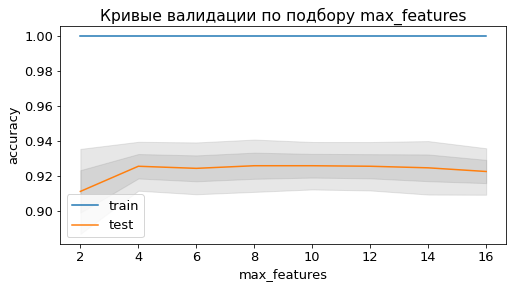

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), label='test')
mu = test_acc.mean(axis=1)
sigma = test_acc.std(axis=1)
ax.fill_between(max_features_grid, mu-sigma, mu+sigma, color='#888888', alpha=0.2)
ax.fill_between(max_features_grid, mu-2*sigma, mu+2*sigma, color='#888888', alpha=0.2)
ax.set_xlabel('max_features')
ax.set_ylabel('accuracy')
ax.legend(loc='best')
plt.title('Кривые валидации по подбору max_features')
plt.show()

#### Нахождение оптимальных параметров с помощью поиска по сетке

In [31]:
%%time

parameters = { 
    'max_features': [2, 4, 6, 8, 10, 12],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7]
}

rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                            n_jobs=-1, oob_score=True)

gcv = GridSearchCV(rfc, parameters, cv=skf, n_jobs=-1, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 10.3min finished


CPU times: user 4.27 s, sys: 382 ms, total: 4.65 s
Wall time: 10min 21s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [32]:
print(gcv.best_score_.round(4), gcv.best_params_)

0.9265 {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1}
